In [1]:
from wrapper_functions import *

TensorFlow version: 2.10.0. Expected: 2.7.0
TensorFlow Probability version: 0.18.0. Expected: 0.15.0


# Default Configs

In [2]:
# GP configs.
y_noise_std = 0.1  # @param
hidden_units = 128  # @param
lengthscale=1.  # @param
l2_regularizer=0.1  # @param

DEFAULT_GP_CONFIG = dict(lengthscale=lengthscale,
                         l2_regularizer=l2_regularizer, 
                         hidden_units=hidden_units, 
                         y_noise_std=y_noise_std)

In [3]:
# BNE model configs.
estimate_mean = "True" # @param ["True", "False"]
estimate_variance = "False" # @param ["True", "False"]
estimate_skewness = "False" # @param ["True", "False"]
variance_prior_mean=0. # @param
skewness_prior_mean=0. # @param

estimate_mean = eval(estimate_mean)
estimate_variance = eval(estimate_variance)
estimate_skewness = eval(estimate_skewness)

DEFAULT_BNE_CONFIG = dict(estimate_mean=estimate_mean,
                          estimate_variance=estimate_variance,
                          estimate_skewness=estimate_skewness,
                          variance_prior_mean=variance_prior_mean,
                          skewness_prior_mean=skewness_prior_mean)

In [4]:
# MAP configs.
map_step_size=0.1 # @param
map_num_steps=10_000 # @param

DEFAULT_MAP_CONFIG = dict(learning_rate=map_step_size,
                          num_steps=map_num_steps)

In [5]:
# MCMC configs.
mcmc_step_size=0.1 # @param
mcmc_sample_size=500 # @param
mcmc_num_steps=10_000 # @param
mcmc_burnin=2_500 # @param
mcmc_nchain=10 # @param
mcmc_seed=0 # @param

DEFAULT_MCMC_CONFIG = dict(step_size=mcmc_step_size, 
                           num_steps=mcmc_sample_size, 
                           burnin=mcmc_burnin, 
                           nchain=mcmc_nchain, 
                           seed=mcmc_seed)

# Experiment II: 2D Spatial Field

### Model Configs

In [6]:
# Optimization configs. 
# Consider reduce below parameters / set to `False` if MCMC is taking too long:
# mcmc_num_steps, mcmc_burnin, mcmc_nchain, mcmc_initialize_from_map.
map_step_size=5e-4   # @param
map_num_steps=10_000  # @param

mcmc_step_size=1e-4 # @param
mcmc_num_steps=1000 # @param

mcmc_nchain=1 # @param
mcmc_burnin=100 # @param
bne_mcmc_initialize_from_map="True" # @param ["False", "True"]

bne_mcmc_initialize_from_map = eval(bne_mcmc_initialize_from_map)


In [7]:
# BMA parameters.
y_noise_std = 0.01  # Note: Changed from 0.1 # @param
bma_gp_lengthscale = 0.9 # @param
bma_gp_l2_regularizer = 0.1 # @param

bma_n_samples_train = 100 # @param
bma_n_samples_eval = 250 # @param
bma_n_samples_test = 250 # @param
bma_seed = 0 # @param


In [8]:
# BNE parameters.
bne_gp_lengthscale = 4 # 5. # @param
bne_gp_l2_regularizer = 5 # 15 # @param
bne_variance_prior_mean = -2.5 # @param
bne_skewness_prior_mean = -2.5 # @param
bne_seed = 0 # @param

In [9]:
bma_config=dict(gp_lengthscale=bma_gp_lengthscale,
                gp_l2_regularizer=bma_gp_l2_regularizer,
                y_noise_std=y_noise_std,
                map_step_size=map_step_size,
                map_num_steps=map_num_steps,
                mcmc_step_size=mcmc_step_size,
                mcmc_num_steps=mcmc_num_steps,
                mcmc_initialize_from_map=False,
                #return_weight_samples=True,
                n_samples_eval=bma_n_samples_eval,
                n_samples_train=bma_n_samples_train,
                n_samples_test=bma_n_samples_test,
                seed=bma_seed)

bne_config = dict(gp_lengthscale=bne_gp_lengthscale,
                  gp_l2_regularizer=bne_gp_l2_regularizer,
                  variance_prior_mean=bne_variance_prior_mean,
                  skewness_prior_mean=bne_skewness_prior_mean,
                  map_step_size=map_step_size,
                  map_num_steps=map_num_steps,
                  mcmc_step_size=mcmc_step_size,
                  mcmc_num_steps=mcmc_num_steps,
                  mcmc_nchain=mcmc_nchain,
                  mcmc_burnin=mcmc_burnin,
                  mcmc_initialize_from_map=bne_mcmc_initialize_from_map,
                  seed=bne_seed)

### Read training/prediction data

In [10]:
training_eastMA = pd.read_csv('./data/training_dataset/training_eastMA.csv')
training_eastMA_noMI = training_eastMA[:51]
training_eastMA_folds = pd.read_csv('./data/training_dataset/training_eastMA_folds.csv')
base_model_predictions_eastMA = pd.read_csv('./data/prediction_dataset/base_model_predictions_eastMA.csv')
display(training_eastMA.shape, training_eastMA_folds.shape, base_model_predictions_eastMA.shape)
print("pred longitude max and min", base_model_predictions_eastMA["lon"].max(),base_model_predictions_eastMA["lon"].min())
print("pred latitude max and min", base_model_predictions_eastMA["lat"].max(),base_model_predictions_eastMA["lat"].min())
#list(base_model_predictions_eastMA.columns)
print("train longitude max and min", training_eastMA["lon"].max(),training_eastMA["lon"].min())
print("train latitude max and min", training_eastMA["lat"].max(),training_eastMA["lat"].min())

(55, 7)

(55, 10)

(84421, 5)

pred longitude max and min -69.93 -73.5
pred latitude max and min 44.3 40.6
train longitude max and min -70.023598 -73.443056
train latitude max and min 44.107524 40.74529


In [11]:
# standardize
X_train1 = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)
X_test1 = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)
X_valid = np.concatenate((X_train1, X_test1), axis=0)
X_centr = np.mean(X_valid, axis=0)
X_scale = np.max(X_valid, axis=0) - np.min(X_valid, axis=0)

X_train1 = (X_train1 - X_centr) / X_scale
X_test1 = (X_test1 - X_centr) / X_scale

Y_train = np.expand_dims(training_eastMA_noMI["aqs"], 1).astype(np.float32)
#Y_test = np.expand_dims(base_model_predictions_eastMA["pred_av"], 1).astype(np.float32)

print("2011 center and scale: ", X_centr, X_scale)

2011 center and scale:  [-72.185104  42.680347] [3.5699997 3.7000008]


In [12]:
base_model_names = ["pred_av", "pred_gs", "pred_caces"]
base_preds_train = tf.stack([training_eastMA_noMI[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
base_preds_test = tf.stack([base_model_predictions_eastMA[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
#base_preds_test
display(base_preds_train.shape, base_preds_test.shape)

TensorShape([51, 3])

TensorShape([84421, 3])

### Wrapper: Plot Utility Function

In [13]:
def posterior_heatmap_2d(plot_data, X,
                         X_monitor=None,
                         cmap='inferno_r',
                         norm=None, 
                         norm_method="percentile",
                         save_addr=''):
    """Plots colored 2d heatmap using scatterplot.

    Args:
        plot_data: (np.ndarray) plot data whose color to visualize over
            2D surface, shape (N, ).
        X: (np.ndarray) locations of the plot data, shape (N, 2).
        X_monitor: (np.ndarray or None) Locations to plot data points to.
        cmap: (str) Name of color map.
        norm: (BoundaryNorm or None) Norm values to adjust color map.
            If None then a new norm will be created according to norm_method.
        norm_method: (str) The name of method to compute norm values.
            See util.visual.make_color_norm for detail.
        save_addr: (str) Address to save image to.

    Returns:
        (matplotlib.colors.BoundaryNorm) A color norm object for color map
            to be passed to a matplotlib.pyplot function.
    """
#     if save_addr:
#         pathlib.Path(save_addr).parent.mkdir(parents=True, exist_ok=True)
#         plt.ioff()

#     if not norm:
#         norm = make_color_norm(plot_data, method=norm_method)

    # 2d color plot using scatter
    plt.figure(figsize=(10, 8))
    plt.scatter(x=X[:, 0], y=X[:, 1],
                s=3,
                c=plot_data, cmap=cmap, norm=norm)
    cbar = plt.colorbar()

    #     plot monitors "lon", "lat"
    if isinstance(X_monitor, np.ndarray):
        plt.scatter(x=X_monitor[:, 0], y=X_monitor[:, 1],
                    s=10, c='black')

    # adjust plot window
    plt.xlim((np.min(X[:, 0]), np.max(X[:, 0])))
    plt.ylim((np.min(X[:, 1]), np.max(X[:, 1])))

    if save_addr:
        plt.savefig(save_addr, bbox_inches='tight')
        plt.close()
        plt.ion()
    else:
        plt.show()

    return norm

In [14]:
from matplotlib.colors import BoundaryNorm
def make_color_norm(color_data, method="percentile"):
    """Makes color palette norm for heatmap plots.

    Args:
        color_data: (np.ndarray or list) Either a single numpy array or
            a list of numpy array that records numeric values to adjust
            color map to.
        method: (str) The name of method to compute norm values:
            percentile: Adjust norm to the raw percentile of color_data.
            residual: Adjust norm to the symmetric range of
                [-min(abs(data)), -max(abs(data))].
                Color norm values will space out evenly in between the range.
            residual_percentile: Similar to 'residual'.
                But color norm values will be adjusted with respect to the
                percentile of abs(data).

    Returns:
        (matplotlib.colors.BoundaryNorm) A color norm object for color map
            to be passed to a matplotlib.pyplot function.
    """
    if isinstance(color_data, list):
        color_data = np.concatenate(color_data)

    if method == "percentile":
        levels = np.percentile(color_data,
                               np.linspace(0, 100, 101))
    elif method == "residual":
        abs_max = np.max(np.abs(color_data))
        levels = np.linspace(-abs_max, abs_max, 101)
    elif method == "residual_percentile":
        abs_levels = np.percentile(np.abs(color_data),
                                   np.linspace(0, 100, 101))
        levels = np.sort(np.concatenate([-abs_levels, abs_levels]))
    else:
        raise ValueError("Method {} is not supported".format(method))

    return BoundaryNorm(levels, 256)

## Default configs

In [15]:
# Optimization configs. 
# Consider reduce below parameters / set to `False` if MCMC is taking too long:
# mcmc_num_steps, mcmc_burnin, mcmc_nchain, mcmc_initialize_from_map.
map_step_size=5e-4   # @param
map_num_steps=10_000  # @param

mcmc_step_size=1e-4 # @param
mcmc_num_steps=1000 # @param

mcmc_nchain=1 # @param
mcmc_burnin=100 # @param
bne_mcmc_initialize_from_map="True" # @param ["False", "True"]

bne_mcmc_initialize_from_map = eval(bne_mcmc_initialize_from_map)

# # BMA parameters.
# y_noise_std = 0.01  # Note: Changed from 0.1 # @param
# bma_gp_lengthscale = 1. # @param
# bma_gp_l2_regularizer = 0.1 # @param

# bma_n_samples_train = 100 # @param
# bma_n_samples_eval = 250 # @param
# bma_n_samples_test = 250 # @param
# bma_seed = 0 # @param

# # BNE parameters.
# bne_gp_lengthscale = 4 # 5. # @param
# bne_gp_l2_regularizer = 5 # 15 # @param
# bne_variance_prior_mean = -2.5 # @param
# bne_skewness_prior_mean = -2.5 # @param
# bne_seed = 0 # @param

# bma_config=dict(gp_lengthscale=bma_gp_lengthscale,
#                 gp_l2_regularizer=bma_gp_l2_regularizer,
#                 y_noise_std=y_noise_std,
#                 map_step_size=map_step_size,
#                 map_num_steps=map_num_steps,
#                 mcmc_step_size=mcmc_step_size,
#                 mcmc_num_steps=mcmc_num_steps,
#                 mcmc_initialize_from_map=False,
#                 n_samples_eval=bma_n_samples_eval,
#                 n_samples_train=bma_n_samples_train,
#                 n_samples_test=bma_n_samples_test,
#                 seed=bma_seed)

# bne_config = dict(gp_lengthscale=bne_gp_lengthscale,
#                   gp_l2_regularizer=bne_gp_l2_regularizer,
#                   variance_prior_mean=bne_variance_prior_mean,
#                   skewness_prior_mean=bne_skewness_prior_mean,
#                   map_step_size=map_step_size,
#                   map_num_steps=map_num_steps,
#                   mcmc_step_size=mcmc_step_size,
#                   mcmc_num_steps=mcmc_num_steps,
#                   mcmc_nchain=mcmc_nchain,
#                   mcmc_burnin=mcmc_burnin,
#                   mcmc_initialize_from_map=bne_mcmc_initialize_from_map,
#                   seed=bne_seed)

## Bayesian Model Averaging

A Bayesian ensemble model where ensemble weights $w_k's$ are parameterized by Gaussian process priors:

$y \sim N(\mu(x), \sigma^2)$ 

$\mu(x) = \sum_{k=1}^K w_k(x) * m_k(x) \quad$  where $\{m_k\}_{k=1}^K$ are base model predictions.

$w(x) = softmax(f(x)) \qquad\;\;\;$ where $w=[w_1, \dots, w_K]$ and $f=[f_1, \dots, f_K]$

$f \stackrel{i.i.d.}{\sim} GaussianProcess(0, k)$




In [16]:
# Model configs.
y_noise_std = 0.1  # @param
lengthscale=1.  # @param
l2_regularizer=0.1  # @param

# MCMC configs.
map_step_size=0.1 # @param
map_num_steps=10_000 # @param

mcmc_step_size=0.1 # @param
mcmc_num_steps=10_000 # @param

# Posterior configs.
bma_n_samples_train = 100 # @param
bma_n_samples_test = 200 # @param
bma_n_samples_eval = 1000  # @param

bma_seed = 0  # @param
bne_seed = 0 # @param

# Assemble into configs.
bma_model_config = DEFAULT_GP_CONFIG.copy()
map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()

bma_model_config.update(dict(lengthscale=lengthscale,
                             l2_regularizer=l2_regularizer,
                             y_noise_std=y_noise_std))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))

mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps))

### Build model

In [17]:
bma_prior, bma_gp_config = bma_dist(X_train1, 
                                    base_preds_train, 
                                    **bma_model_config)

bma_model_config.update(bma_gp_config)

# Check if the model graph is specified correctly.
bma_prior.resolve_graph()

/Users/liyanran/opt/anaconda3/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer OrthogonalRandomFeatures is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


(('gp_weights', ()), ('y', ('gp_weights',)))

In [18]:
display(map_config,mcmc_config)

{'learning_rate': 0.1, 'num_steps': 10000}

{'step_size': 0.1, 'num_steps': 10000, 'burnin': 2500, 'nchain': 10, 'seed': 0}

### Run MCMC

In [19]:
bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior, 
                                           model_config=bma_model_config,
                                           Y=Y_train, 
                                           map_config=map_config,
                                           mcmc_config=mcmc_config)


bma_joint_samples = make_bma_samples(X_test1, None, base_preds_test, 
                                     bma_weight_samples=bma_gp_w_samples[0],
                                     bma_model_config=bma_model_config, 
                                     n_samples=bma_n_samples_eval, 
                                     seed=bne_seed,
                                     y_samples_only=False)



Running MAP:	4905.0517578125...3057.98095703125...3054.28662109375...3054.0400390625...3054.03662109375...3054.3310546875...3054.12841796875...3054.05859375...3054.6181640625...3054.2041015625...Done.
Running MCMC:	Acceptance Ratio: 0.6860882043838501


### Prepare Data for BAE/BNE

In [20]:
# Construct data from BMA samples, shapes (num_samples * num_data, ...)
means_train_mcmc, X_train_mcmc, Y_train_mcmc = make_bma_samples(
    X_train1, Y_train, base_preds_train, 
    bma_weight_samples=bma_gp_w_samples[0],
    bma_model_config=bma_model_config,
    n_samples=bma_n_samples_train,
    seed=bma_seed, 
    prepare_mcmc_training=True)

# Mean samples based on test data, shape (num_samples, num_data, num_output).
# It is used to generate final examples in `make_bne_samples()`.
means_test_mcmc = make_bma_samples(
    X_test1, None, base_preds_test, 
    bma_weight_samples=bma_gp_w_samples[0],
    bma_model_config=bma_model_config,
    n_samples=bma_n_samples_test,
    seed=bma_seed)

In [21]:
display(means_train_mcmc.shape, X_train_mcmc.shape, Y_train_mcmc.shape, means_test_mcmc.shape)

TensorShape([5100, 1])

TensorShape([5100, 2])

TensorShape([5100, 1])

TensorShape([200, 84421, 1])

## Bayesian Additive Ensemble

Given $\mu(x)$ the posterior of a Bayesian ensemble model, the Bayesian Additive Ensemble is defined as:    

$y \sim N(\mu(x) + r(x), \sigma^2)$

$r \sim GaussianProcess(0, k)$

The additive ensemble $r(x)$ services two purposes: 

1. Mitigates systematic bias in model prediction; 
2. Quantifies the model's epistemic uncertainty.

In [22]:
# BNE GP Configs.
lengthscale = 1. # @param
l2_regularizer = 10. # @param

# BNE model configs. 
# If estimate_mean=False, only estimates a constant variance on top of the 
# original model.
estimate_mean = "True" # @param ["True", "False"]
variance_prior_mean=0. # @param
# MAP and MCMC configs
map_step_size=0.1 # @param
map_num_steps=10_000 # @param

mcmc_step_size=1e-2 # @param
mcmc_num_steps=10_000 # @param



bne_gp_config = DEFAULT_GP_CONFIG.copy()
bne_model_config = DEFAULT_BNE_CONFIG.copy()

map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()


bne_gp_config.update(dict(lengthscale=lengthscale, 
                          l2_regularizer=l2_regularizer))
bne_model_config.update(dict(estimate_mean=eval(estimate_mean),
                             variance_prior_mean=variance_prior_mean,
                             **bne_gp_config))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))
mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps))

### Build Model

In [23]:
# Construct posterior sampler.
bne_prior, bne_gp_config = bne_model_dist(
    inputs=X_train_mcmc,
    mean_preds=means_train_mcmc,
    **bne_model_config)

bne_model_config.update(bne_gp_config)
print(f'prior model graph: {bne_prior.resolve_graph()}')

prior model graph: (('gp_weights', ()), ('y', ('gp_weights',)))


### Run MCMC

In [24]:
# Estimates GP weight posterior using MCMC.
bne_gp_w_samples = run_posterior_inference(model_dist=bne_prior,
                                           model_config=bne_gp_config,
                                           Y=Y_train_mcmc,
                                           map_config=map_config,
                                           mcmc_config=mcmc_config,
                                           initialize_from_map=True)
# Generates the posterior sample for all model parameters. 
bne_joint_samples = make_bne_samples(X_test1,
                                     mean_preds=means_test_mcmc,
                                     bne_model_config=bne_model_config,
                                     bne_weight_samples=bne_gp_w_samples[0],
                                     seed=bne_seed)

Running MAP:	10383.7451171875...8715.1630859375...8715.1865234375...8715.21484375...8715.1787109375...8715.21484375...8715.232421875...8715.2890625...8715.240234375...8715.185546875...Done.
Running MCMC:	Acceptance Ratio: 0.8251184821128845


In [25]:
surface_pred_bae = {k: np.mean(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}
surface_var_bae = {k: np.var(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}

# dealing with NA

In [26]:
# percentile of NAN
np.sum(np.isnan(np.mean(bne_joint_samples['mean_original'], axis=0)))/84421

0.005235664112010045

## Bayesian Nonparametric Ensemble (Variance Only)
So far, we are only estimating the mean-component of the model, i.e., we are assuming: 

$y \sim Gaussian(m(x), \sigma^2); \quad m(x) = GP(0, k)$.

By doing so, the model is implicitly assuming the distribution of $y$ is always a symmetric Gaussian distribution with constant mean across space and time. As a result, our model can only quantify model uncertainty (due to lack of data) via the GP prior, but cannot flexibly capture the data uncertainty that is inherent to the empirical distribution of y.

To resolve this, we extend the ensemble's outcome distribution $y | f$ by also estimating the higher moments of the data distribution (e.g., variance, skewness, etc) using flexible estimators. Specifically, we specify the outcome distribution family to the [maximum-entropy distribution](https://en.wikipedia.org/wiki/Principle_of_maximum_entropy) given the known moments, so the predictive distribution is [minimax](https://arxiv.org/pdf/math/0410076.pdf) and still statistically efficient to estimate.

For example, when we want to estimate the first two moments (mean and variance) of the distribution, this leads to a Gaussian distribution with spatio-temporally adaptive variance $\sigma(x)^2$:

$$y \sim Gaussian(m(x), \sigma(x)^2); \quad \mbox{where} \quad m \sim GP(0, k_m), \sigma \sim GP(0, k_\sigma)$$

and when we want to estimate the first three moments (mean and variance) of the distribution, this leads to a [Exponentially-modifed Gaussian](https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution) (EMG) distribution with spatio-temporally adaptive variance $\sigma(x)^2$ and skewness $\lambda(x)$:

$$y \sim EMG(m(x), \sigma(x)^2, \lambda(x)); \quad \mbox{where} \quad m \sim GP(0, k_m), \sigma \sim GP(0, k_\sigma), \lambda \sim GP(0, k_\lambda)$$




In [27]:
# Default configs
# BNE GP Configs.
lengthscale = 1. # @param
l2_regularizer = 10. # @param

# BNE model configs.
variance_prior_mean=0. # @param
# MAP and MCMC configs

map_step_size=5e-3 # @param
map_num_steps=10_000 # @param

mcmc_step_size=1e-2 # @param
mcmc_num_steps=10_000 # @param


bne_gp_config = DEFAULT_GP_CONFIG.copy()
bne_model_config = DEFAULT_BNE_CONFIG.copy()

map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()


bne_gp_config.update(dict(lengthscale=lengthscale, 
                          l2_regularizer=l2_regularizer))
bne_model_config.update(dict(estimate_variance=True,
                             variance_prior_mean=variance_prior_mean,
                             **bne_gp_config))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))
mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps))

### Define Model & Run MCMC

In [28]:
# Construct posterior sampler.
bne_prior, bne_gp_config = bne_model_dist(
    inputs=X_train_mcmc,
    mean_preds=means_train_mcmc,
    **bne_model_config)

bne_model_config.update(bne_gp_config)
print(f'prior model graph: {bne_prior.resolve_graph()}')

# Estimates GP weight posterior using MCMC.
bne_gp_w_samples = run_posterior_inference(model_dist=bne_prior,
                                           model_config=bne_gp_config,
                                           Y=Y_train_mcmc,
                                           map_config=map_config,
                                           mcmc_config=mcmc_config,
                                           initialize_from_map=True)
# Generates the posterior sample for all model parameters. 
bne_joint_samples = make_bne_samples(X_test1,
                                     mean_preds=means_test_mcmc,
                                     bne_model_config=bne_model_config,
                                     bne_weight_samples=bne_gp_w_samples[0],
                                     seed=bne_seed)

prior model graph: (('gp_weights', ()), ('y', ('gp_weights',)))
Running MAP:	10357.904296875...8433.1015625...8433.1015625...8433.1015625...8433.1015625...8433.1005859375...8433.1015625...8433.1005859375...8433.1064453125...8433.1005859375...Done.
Running MCMC:	Acceptance Ratio: 0.791915774345398


In [29]:
surface_pred_bne_vo = {k: np.mean(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}
surface_var_bne_vo = {k: np.var(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}



## Bayesian Nonparametric Ensemble (Variance + Skewness)

In [30]:
# BNE GP Configs.
lengthscale = 1. # @param
l2_regularizer = 10. # @param

# BNE model configs.
variance_prior_mean=0. # @param
skewness_prior_mean=0. # @param
# MAP and MCMC configs
map_step_size=5e-3 # @param
map_num_steps=10_000 # @param

mcmc_step_size=1e-2 # @param
mcmc_num_steps=10_000 # @param

bne_gp_config = DEFAULT_GP_CONFIG.copy()
bne_model_config = DEFAULT_BNE_CONFIG.copy()

map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()


bne_gp_config.update(dict(lengthscale=lengthscale, 
                          l2_regularizer=l2_regularizer))
bne_model_config.update(dict(estimate_variance=True,
                             estimate_skewness=True,
                             variance_prior_mean=variance_prior_mean,
                             skewness_prior_mean=skewness_prior_mean,
                             **bne_gp_config))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))
mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps))

### Define Model & Run MCMC

In [31]:
# Construct prior distribution.
bne_prior, bne_gp_config = bne_model_dist(
    inputs=X_train_mcmc,
    mean_preds=means_train_mcmc,
    **bne_model_config)

bne_model_config.update(bne_gp_config)
print(f'prior model graph: {bne_prior.resolve_graph()}')
# Estimates GP weight posterior using MCMC.
bne_gp_w_samples = run_posterior_inference(model_dist=bne_prior,
                                           model_config=bne_gp_config,
                                           Y=Y_train_mcmc,
                                           map_config=map_config,
                                           mcmc_config=mcmc_config,
                                           initialize_from_map=True)
# Generates the posterior sample for all model parameters. 
bne_joint_samples = make_bne_samples(X_test1,
                                     mean_preds=means_test_mcmc,
                                     bne_model_config=bne_model_config,
                                     bne_weight_samples=bne_gp_w_samples[0],
                                     seed=bne_seed)

prior model graph: (('gp_weights', ()), ('y', ('gp_weights',)))
Running MAP:	12333.5087890625...8388.2255859375...8388.2255859375...8388.2255859375...8388.2255859375...8388.2255859375...8388.2255859375...8388.2265625...8388.2255859375...8388.2275390625...Done.
Running MCMC:	Acceptance Ratio: 0.7929874658584595


In [32]:
surface_pred_bne_vs = {k: np.mean(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}
surface_var_bne_vs = {k: np.var(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}

## Basic Plots

In [61]:
#_DATA_ADDR_PREFIX = "./example/data"
# Tuning Parameters
BMA_lenthscale = bma_gp_lengthscale
BNE_lenthscale = bne_gp_lengthscale
BMA_L2 = bma_gp_l2_regularizer
BNE_L2 = bne_gp_l2_regularizer
_SAVE_ADDR_PREFIX = "./pic/BMA_lenthscale_{}_L2_{}_BNE_lenthscale_{}_L2_{}".format(BMA_lenthscale, BMA_L2, BNE_lenthscale, BNE_L2)

# path=path.strip() #去除首位空格
# path=path.rstrip("\\") # 去除尾部 \ 符号
# isExists=os.path.exists(path) #判断路径是否存在，存在则返回true
path=_SAVE_ADDR_PREFIX
isExists=os.path.exists(path) #判断路径是否存在，存在则返回true

if not isExists:
    os.makedirs(path)


### 1. The predictive surface of individual base models.

In [62]:
coordinate = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)
monitors = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)
base_model_names = ["pred_av", "pred_gs", "pred_caces"]

base_model_predictions_eastMA[["pred_av", "pred_gs", "pred_caces"]] = np.where(np.isnan(base_model_predictions_eastMA[["pred_av", "pred_gs", "pred_caces"]]), 0, base_model_predictions_eastMA[["pred_av", "pred_gs", "pred_caces"]])
color_norm_base = make_color_norm(
    base_model_predictions_eastMA[["pred_av", "pred_gs", "pred_caces"]],   
    method="percentile")

for base_model_name in base_model_names:
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                             'base_model_{}_bmals_{}_r_{}_bnels_{}_r_{}.png'.format(
                                 base_model_name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                 bne_gp_lengthscale, bne_gp_l2_regularizer))
    
    posterior_heatmap_2d(base_model_predictions_eastMA[base_model_name], coordinate,
                         monitors,
                         cmap='RdYlGn_r',
                         norm=color_norm_base, 
                         #norm_method="percentile",
                         save_addr=save_name)

### 2. The predictive surface of individual BNE gp weights

In [35]:
bma_ensemble_weights = bma_joint_samples['ensemble_weights']
ensemble_weights_val = tf.reduce_mean(bma_ensemble_weights, axis=0)

weights_dict = {
    "AV": ensemble_weights_val[:, 0],
    "GS": ensemble_weights_val[:,1],
    "CACES": ensemble_weights_val[:,2],
}
#weights_dict
color_norm_weights = make_color_norm(
    list(weights_dict.values()),#[2],   
    method="percentile")

In [36]:
ensemble_weights_var = np.var(bma_ensemble_weights, axis=0)
weights_var_dict = {
    "AV": ensemble_weights_var[:, 0],
    "GS": ensemble_weights_var[:,1],
    "CACES": ensemble_weights_var[:,2],
}
#weights_dict
color_norm_weights_var = make_color_norm(
    list(weights_var_dict.values()),#[0],   
    method="percentile")
# display(ensemble_weights_val,ensemble_weights_var)

In [53]:
base_model_names = ["AV", "GS", "CACES"]
for base_model_name in base_model_names:
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                             'baseweights_{}_bmals_{}_r_{}_bnels_{}_r_{}.png'.format(
                                 base_model_name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                 bne_gp_lengthscale, bne_gp_l2_regularizer))
    
    posterior_heatmap_2d(weights_dict[base_model_name], coordinate,
                         monitors,
                         cmap='viridis',
                         norm=color_norm_weights, 
                         #norm_method="percentile",
                         #save_addr='')
                         save_addr=save_name)

In [54]:
# plot weights' variance
for base_model_name in base_model_names:
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                             'basew_var_{}_bmals_{}_r_{}_bnels_{}_r_{}.png'.format(
                                 base_model_name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                 bne_gp_lengthscale, bne_gp_l2_regularizer))
    
    posterior_heatmap_2d(weights_var_dict[base_model_name], coordinate,
                         monitors,
                         cmap='viridis',
                         norm=color_norm_weights_var, 
                         #norm_method="percentile",
                         #save_addr='')
                         save_addr=save_name)

### 3. The predictive surface of Y_mean, residual process, and Y_mean + residual process.

In [64]:
# BAE
color_norm_pred = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[:2][0]),
    list(surface_pred_bae.values())[:2],  
    method="percentile")

color_norm_pred_r = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[2:]),
    list(surface_pred_bae.values())[2],  
    method="residual_percentile")


for name, value in surface_pred_bae.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            '{}_BAE_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(
                                name,
                                base_model_name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                bne_gp_lengthscale, bne_gp_l2_regularizer))

    value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                                  cmap='RdYlGn_r',
                    norm= color_norm_pred_r if name=='resid' else color_norm_pred,
                    #norm_method="percentile",
                    #save_addr='')
                    save_addr=save_name)
    

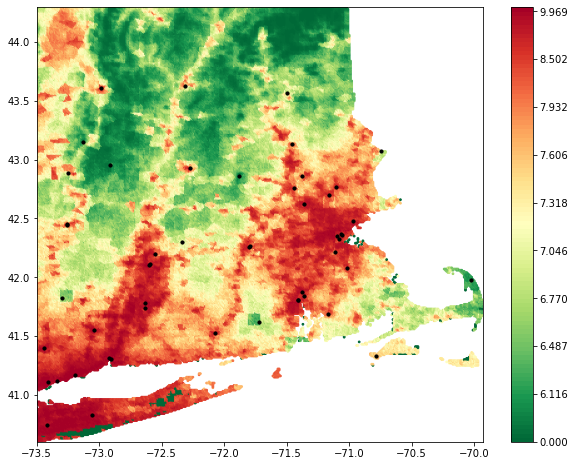

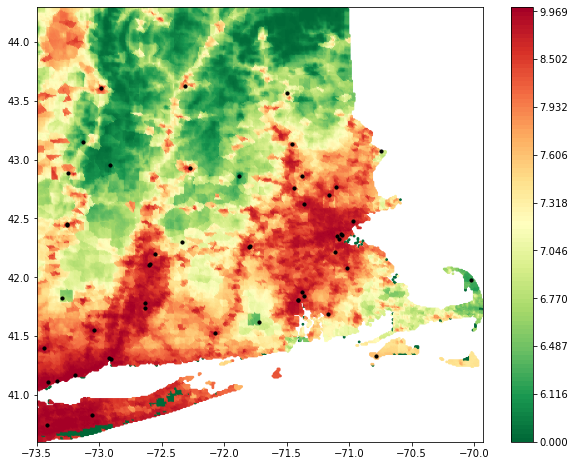

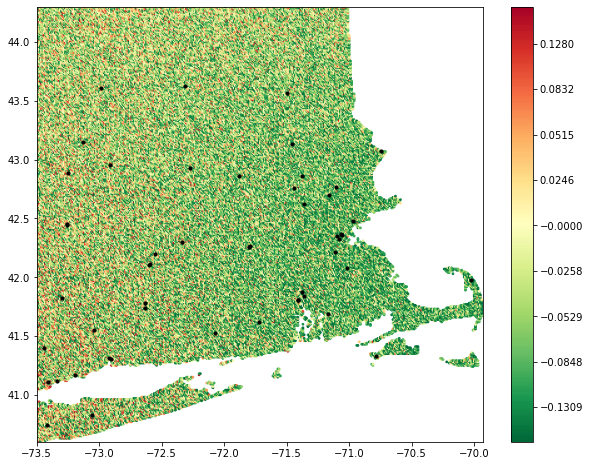

In [40]:
# BNE vo
color_norm_pred = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[:2][0]),
    list(surface_pred_bne_vo.values())[:2],  
    method="percentile")

color_norm_pred_r = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[2:]),
    list(surface_pred_bne_vo.values())[2],  
    method="residual_percentile")


for name, value in surface_pred_bne_vo.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            '{}_BNEvo_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(
                                name,
                                base_model_name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                bne_gp_lengthscale, bne_gp_l2_regularizer))

    value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                                  cmap='RdYlGn_r',
                    norm= color_norm_pred_r if name=='resid' else color_norm_pred,
                                      save_addr=save_name)
                    #norm_method="percentile",
                    #save_addr='')
    

In [66]:
# BNE v+s
color_norm_pred = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[:2][0]),
    list(surface_pred_bne_vs.values())[:2],  
    method="percentile")

color_norm_pred_r = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[2:]),
    list(surface_pred_bne_vs.values())[2],  
    method="residual_percentile")


for name, value in surface_pred_bne_vs.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            '{}_BNEvs_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(name,
                                base_model_name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                bne_gp_lengthscale, bne_gp_l2_regularizer))

    value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                                  cmap='RdYlGn_r',
                    norm= color_norm_pred_r if name=='resid' else color_norm_pred,
                    #norm_method="percentile",
                    #save_addr='')
                save_addr=save_name)
    

### 4.The predictive variance of Y_mean, residual process, and Y.

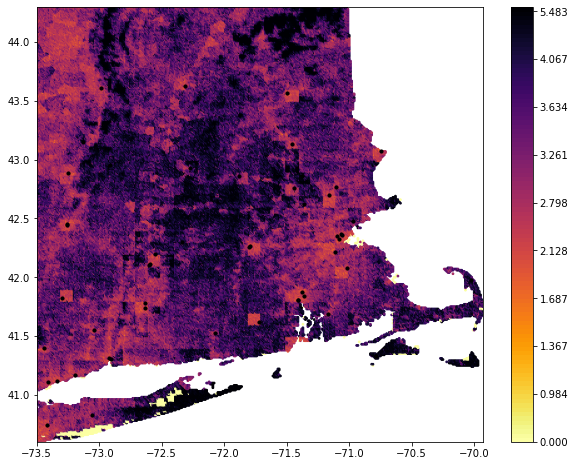

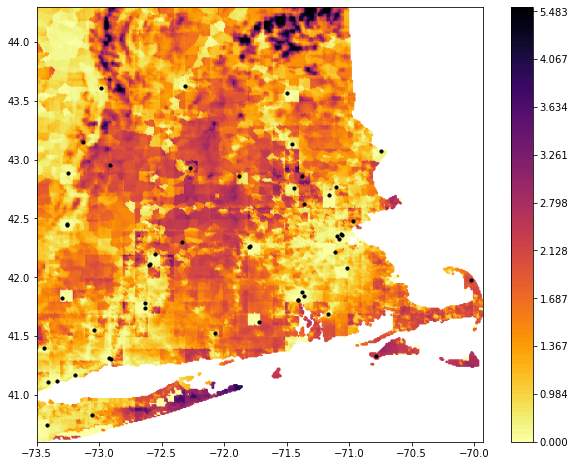

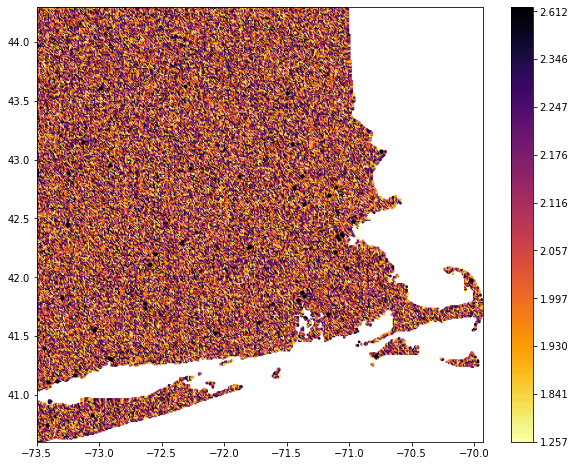

In [42]:
# BAE
color_norm_var = make_color_norm(
    list(surface_var_bae.values())[:2], 
    method="percentile")

color_norm_var_r = make_color_norm(
    list(surface_var_bae.values())[2], 
    method="percentile")


for name, value in surface_var_bae.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            '{}_var_BAE_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(
                                name,
                                base_model_name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                bne_gp_lengthscale, bne_gp_l2_regularizer))
    #value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                cmap='inferno_r',
                                norm= color_norm_var_r if name=='resid' else color_norm_var,
                                #norm_method="percentile",
                                save_addr='')

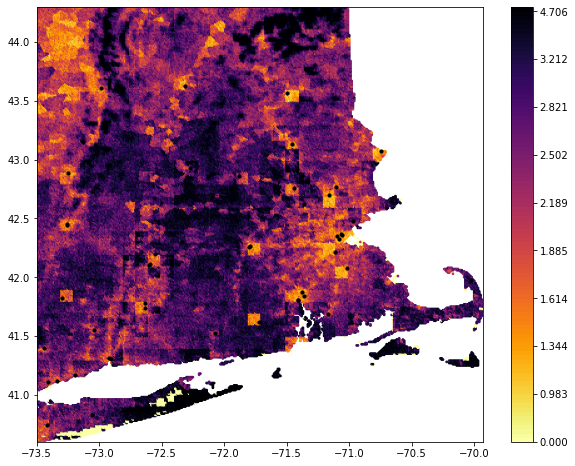

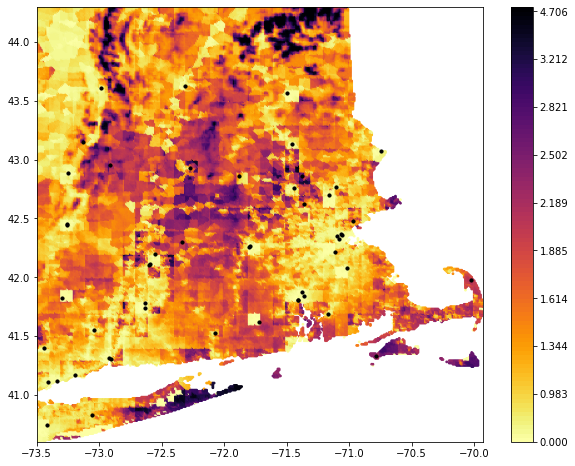

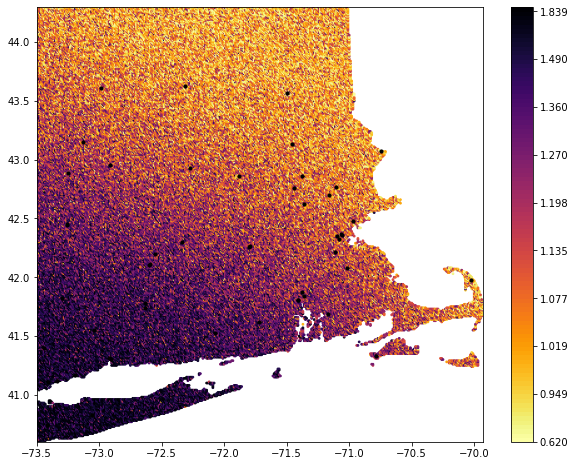

In [43]:
# BNE vo
color_norm_var = make_color_norm(
    list(surface_var_bne_vo.values())[:2], 
    method="percentile")

color_norm_var_r = make_color_norm(
    list(surface_var_bne_vo.values())[2], 
    method="percentile")


for name, value in surface_var_bne_vo.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            '{}_var_BNEvo_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(
                                name,
                                base_model_name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                bne_gp_lengthscale, bne_gp_l2_regularizer))
    #value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                cmap='inferno_r',
                                norm= color_norm_var_r if name=='resid' else color_norm_var,
                                #norm_method="percentile",
                                save_addr='')

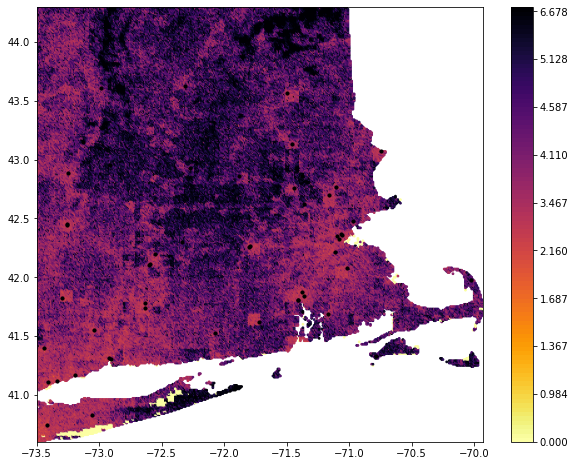

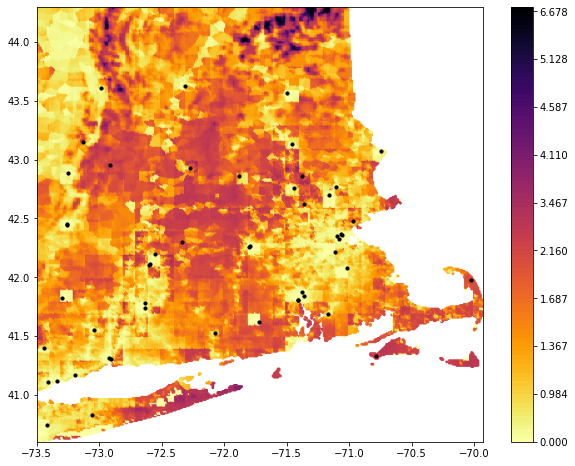

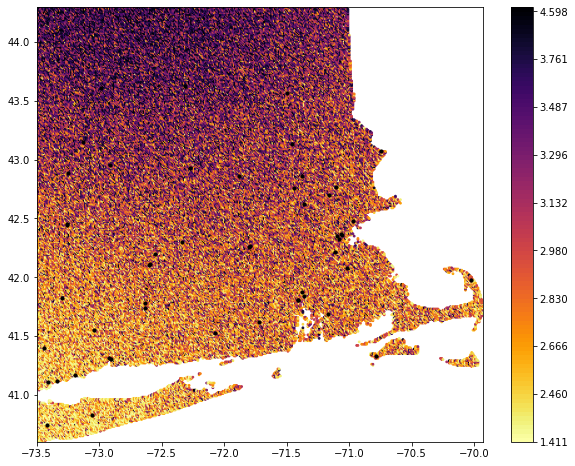

In [44]:
# BNE v+s
color_norm_var = make_color_norm(
    list(surface_var_bne_vs.values())[:2], 
    method="percentile")

color_norm_var_r = make_color_norm(
    list(surface_var_bne_vs.values())[2], 
    method="percentile")


for name, value in surface_var_bne_vs.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            '{}_var_BNEvs_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(
                                name,
                                base_model_name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                bne_gp_lengthscale, bne_gp_l2_regularizer))
    #value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                cmap='inferno_r',
                                norm= color_norm_var_r if name=='resid' else color_norm_var,
                                #norm_method="percentile",
                                save_addr='')

### Evaluation

In [45]:
# base_preds_train, base_preds_test, kernel_names = run_base_models(
#       X_train1, X_train1, X_test1, Y_train, Y_train, Y_test, num_train_steps=100, debug_mode=False)

# d0 = dict(X_base=X_train1,
#                    X_train=X_train1,
#                    X_test=X_test1,
#                    Y_base=Y_train, 
#                    Y_train=Y_train, 
#                    Y_test=Y_test, 
#                    mean_test=Y_test, 
#                    base_preds_train=base_preds_train, 
#                    base_preds_test=base_preds_test, 
#                    base_model_names=kernel_names)

# d0 = dict(X_train=X_train1,
#                    X_test=X_test1,
#                    Y_train=Y_train, 
#                   # Y_test=Y_test, 
#                    mean_test=Y_test, 
#                    base_preds_train=base_preds_train, 
#                    base_preds_test=base_preds_test, 
#                    base_model_names=base_model_names)
# seed = 1

# def run_single2D():
#     # Data Generation
#     #data_dicts = {}
#     data_dicts = d0
#     # dict_keys(['X_base', 'X_train', 'X_test', 'Y_base', 'Y_train', 'Y_test', 'mean_test', 'base_preds_train', 'base_preds_test', 'base_model_names'])

#     # BMA-mean.
#     data_dicts = get_bma_result(d0, bma_config=bma_config) 
    
# #     BMA.
# #     Inhere BMA MCMC configs.
#     bma_var_config = bne_config.copy()
#     bma_var_config['mcmc_initialize_from_map'] = bma_config['mcmc_initialize_from_map']
#     gp_weights, data_dicts = get_bne_result(data_dicts, moment_mode='none', 
#                                       bne_config=bma_var_config) 

# #     # BAE.
# #     data_dicts = get_bne_result(data_dicts, moment_mode='mean', 
# #                                       bne_config=bne_config) 
# #     print(data_dicts.keys())

# #     # BNE-Variance.
# #     data_dicts = get_bne_result(data_dicts, moment_mode='variance', 
# #                                       bne_config=bne_config) 


# #     # BNE-Skewness.
# #     data_dicts = get_bne_result(data_dicts, moment_mode='skewness', 
# #                                       bne_config=bne_config) 

#     return gp_weights, data_dicts

# gp_weights1, plt_dict1 = run_single2D()    
 



In [46]:
# posterior_heatmap_2d(eastMA_pred, plt_dict1["X_test"],
#                          plt_dict1["X_train"],
#                          cmap='RdYlGn_r',
#                          norm=None, norm_method="percentile",
#                          save_addr='')
# posterior_heatmap_2d(eastMA_pred, np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32),
#                          np.asarray(training_eastMA_folds[["lon", "lat"]].values.tolist()).astype(np.float32),
#                          cmap='RdYlGn_r',
#                          norm=None, norm_method="percentile",
#                          save_addr='')
# eastMA_pred_var = np.var(plt_dict1["bne_var_samples"], axis=0)
# posterior_heatmap_2d(eastMA_pred_var, plt_dict1["X_test"],
#                          plt_dict1["X_train"],
#                          cmap='inferno_r',
#                          norm=None, norm_method="percentile",
#                          save_addr='')